# Introduction - Story 1

## Intro

Contents.

Intro Text.

Based on https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsinvolvingcovid19bylocalareasanddeprivation/latest

### Data Sources

ONS datasets:

- [Mortality count time series](https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/causesofdeath/datasets/deathregistrationsandoccurrencesbylocalauthorityandhealthboard)
- [IMD Rankings (England only)](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019)
- [Populations](https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationestimates%2fdatasets%2fpopulationestimatesforukenglandandwalesscotlandandnorthernireland%2fmid20182019laboundaries/ukmidyearestimates20182019ladcodes.xls)
- [Local Authority District Code Region Lookup Table](https://opendata.arcgis.com/datasets/3ba3daf9278f47daba0f561889c3521a_0.csv)
- [ONS Mortality and Depravation Data](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/deathsinvolvingcovid19bylocalareaanddeprivation)

In case any of the data sources become unavailable in the future, a download mirror is availible [here](https://drive.google.com/drive/folders/1NXp7DtBeCbTIv49_ngdgvQpQXaaB3f8F?usp=sharing).

# Setup & Data Collation

In [1]:
from datetime import datetime
import os
import requests

import zipfile

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
sns.set_style('ticks')

Set some data locations and make directories if needed.

In [2]:
# downloaded data goes here
downloaded_data_dir = 'data/downloaded'

# processed data goes here
derived_data_dirname = 'data/derived'

# create the directory if it does not already exist
os.makedirs(downloaded_data_dir, exist_ok=True)
os.makedirs(derived_data_dirname, exist_ok=True)

In [3]:
def download_file(url, filename):
    
    # if the file already exists, return without redownloading
    if os.path.exists(filename):
        return
        
    # create the directory if it does not already exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # make the HTTP request
    r = requests.get(url, allow_redirects=True)

    # save file
    _ = open(filename, 'wb').write(r.content)


## Index of Multiple Deprevation

### Download and Format

In [4]:
# specify URL
url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/833970/File_1_-_IMD2019_Index_of_Multiple_Deprivation.xlsx'

# specify filename
filename = 'ONS_2019_Index_of_Multiple_Deprivation.xlsx'

# construct file path
filepath = os.path.join(downloaded_data_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

# read the relevant sheet
imd_df = pd.read_excel(filepath, sheet_name='IMD2019')

If we sort by deprivation rank, we can get an idea for the most / least deprived LSOAs.

In [5]:
imd_df.sort_values(by='Index of Multiple Deprivation (IMD) Rank')

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Rank,Index of Multiple Deprivation (IMD) Decile
21400,E01021988,Tendring 018A,E07000076,Tendring,1,1
12280,E01012673,Blackpool 010A,E06000009,Blackpool,2,1
12288,E01012681,Blackpool 006A,E06000009,Blackpool,3,1
12279,E01012672,Blackpool 013B,E06000009,Blackpool,4,1
12278,E01012671,Blackpool 013A,E06000009,Blackpool,5,1
...,...,...,...,...,...,...
17759,E01018293,South Cambridgeshire 012B,E07000012,South Cambridgeshire,32840,10
15715,E01016187,Bracknell Forest 002D,E06000036,Bracknell Forest,32841,10
30976,E01031773,Mid Sussex 008D,E07000228,Mid Sussex,32842,10
26986,E01027699,Harrogate 021A,E07000165,Harrogate,32843,10


IMD table data has higher spatial resolution that the mortality data. We need to comibne the IMD rank to create a Local Authority District level rank. Let's construct a simple DataFrame that maps LAD code to mean IMD rank

### Derive Mean IMD Rank

In [6]:
def get_mean_IMD_rank(LAD_code):
    """
    TODO: map mean rank to [0,1] to make the number easier to understand.
    """
    # select relevant LSOAs
    LSOAs = imd_df[imd_df['Local Authority District code (2019)'] == LAD_code]
    
    # calculate mean IMD rank
    mean_IMD_rank = round(LSOAs['Index of Multiple Deprivation (IMD) Rank'].mean())
 
    return mean_IMD_rank

def get_mean_IMD_decile(LAD_code):
    """
    TODO: map mean rank to [0,1] to make the number easier to understand.
    """
    # select relevant LSOAs
    LSOAs = imd_df[imd_df['Local Authority District code (2019)'] == LAD_code]
    
    # calculate mean IMD rank
    mean_IMD_decile = round(LSOAs['Index of Multiple Deprivation (IMD) Decile'].mean(),1)
    std_IMD_decile = round(LSOAs['Index of Multiple Deprivation (IMD) Decile'].std(),1)
    
    return mean_IMD_decile, std_IMD_decile

In [7]:
LAD_codes = imd_df['Local Authority District code (2019)'].unique()
mean_IMD_ranks = np.vectorize(get_mean_IMD_rank)(LAD_codes)
mean_IMD_decile, std_IMD_decile  = np.vectorize(get_mean_IMD_decile)(LAD_codes)



LAD_df = pd.DataFrame({'LAD Code': LAD_codes, 
                       'LAD Name': imd_df['Local Authority District name (2019)'].unique(),
                       'Mean IMD Rank': mean_IMD_ranks,
                       'Mean IMD decile': mean_IMD_decile,
                       'Std IMD decile': std_IMD_decile})

LAD_df = LAD_df.set_index('LAD Code')

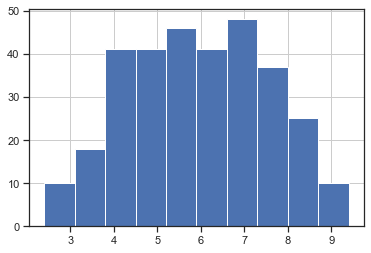

In [8]:
LAD_df['Mean IMD decile'].hist()
plt.show()

As expected, we lose some information when aggregating IMD ranks in this way. The central part of the distribution is relatively flat, and we cannot differentiate well between LADs in this region.

### Derive Age Standardisation Weight

In this section, we use [data](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/deathsinvolvingcovid19bylocalareaanddeprivation) from the ONS study on COVID-19 and deprivation to derive a factor which will allow us to convert our mortality counts into an age and population standardise mortality rate. This mortality rate is a European standard (2013 ESP). We cannot calcualte it directly as ONS have not released the required data, so this reverse engineering is the best we can do.

First, let's download and read the data.

In [9]:
# download the ONS data from the deprivation study
url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fdeathsinvolvingcovid19bylocalareaanddeprivation%2f1march2020to17april2020/referencetablesdraft.xlsx'

# specify filename
filename = 'ONS_age_standarisation_April2020.xlsx'

# construct file path
filepath = os.path.join(downloaded_data_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

# read the relevant sheet
age_rate_df = pd.read_excel(filepath, sheet_name='Table 2', header=3)

Do some minor selection and reformatting of the DataFrame.

In [10]:
# data if given for many categories and regios, lets choose the inclusive gender, and the unitary authority levels
age_rate_persons_df = age_rate_df[age_rate_df['Sex']=='Persons'] 

# rename columns
age_rate_persons_df.columns = ['Sex', 'Geography type', 'LAD Code', 'Area name', 'All causes Deaths',
       'All causes Rate','' ,'All causes Lower CI', 'All causes Upper CI','' ,'COVID-19 Deaths',
       'COVID-19 Rate', '','COVID-19 Lower CI', 'COVID-19 Upper CI' ]

# remove anomalous row (Isles of Scilly) without numerical data
age_rate_persons_df = age_rate_persons_df[age_rate_persons_df['All causes Rate'] != ':']
age_rate_persons_df = age_rate_persons_df[age_rate_persons_df['COVID-19 Rate'] != ':']

age_rate_persons_df.head()

,Sex,Geography type,LAD Code,Area name,All causes Deaths,All causes Rate,,All causes Lower CI,All causes Upper CI,,COVID-19 Deaths,COVID-19 Rate,,COVID-19 Lower CI,COVID-19 Upper CI
1,Persons,Unitary Authority,E06000001,Hartlepool,154,170.7,NaN,143.5,197.8,NaN,29,31,NaN,20.7,44.5
2,Persons,Unitary Authority,E06000002,Middlesbrough,289,256,NaN,226.1,286,NaN,89,79,NaN,63.2,97.6
3,Persons,Unitary Authority,E06000003,Redcar and Cleveland,215,142.6,NaN,123.5,161.8,NaN,40,26.5,NaN,18.9,36.2
4,Persons,Unitary Authority,E06000004,Stockton-on-Tees,297,167,NaN,147.8,186.1,NaN,38,21,NaN,14.8,28.9
5,Persons,Unitary Authority,E06000005,Darlington,169,151.5,NaN,128.6,174.4,NaN,26,22.9,NaN,15,33.7


Calculate the factor which you need to multiply the count of deaths by in order to derive the age-standardised mortality rate per 100,000 habitants.

In [11]:
# derive standardisation factors
age_rate_persons_df['All causes rate factor'] = (
    age_rate_persons_df['All causes Rate'] / age_rate_persons_df['All causes Deaths'] )

age_rate_persons_df['COVID-19 rate factor'] = (
    age_rate_persons_df['COVID-19 Rate'] / age_rate_persons_df['COVID-19 Deaths'] )

# drop columns
age_rate_persons_df = age_rate_persons_df[['LAD Code', 'All causes rate factor', 'COVID-19 rate factor']]

In [12]:
LAD_df = LAD_df.reset_index()
LAD_df = LAD_df.merge(age_rate_persons_df, on='LAD Code', how='inner')
LAD_df = LAD_df.set_index('LAD Code')

Let's save the `LAD_df` table we've created, so that we can easily use it as a lookup table. 

In [13]:
# create filename
LAD_df_filename = 'Local_Authority_District_Lookup.csv'
LAD_df_filepath = os.path.join(derived_data_dirname, LAD_df_filename)

# write to csv
LAD_df.to_csv(LAD_df_filepath, index=False)

## Mortality Counts

### Download and Format

First, let's download the ONS dataset containing mortality counts by week and local authority.

In [14]:
# specify URL
url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fhealthandsocialcare%2fcausesofdeath%2fdatasets%2fdeathregistrationsandoccurrencesbylocalauthorityandhealthboard%2f2020/lahbtablesweek20finalcodes.xlsx'

# specify filename
filename = 'ONS_COVID_Mortality_Counts.xlsx'

# construct file path
filepath = os.path.join(downloaded_data_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

In [15]:
# specify the sheet of the excel file we want to read
sheet_name = 'Registrations - All data'

# read the sheet into a pandas DataFrame
mortality_df = pd.read_excel(filepath, sheet_name=sheet_name, header=3)

Let's quickly check that we have 1:1 correspondence between LAD codes in the mortality dataset and in the IMD dataset.

In [16]:
print('Number of unique LAD Codes in mortality data =', len(mortality_df['Area code'].unique()))
print('Number of unique LAD Codes in IMD data =', len(imd_df['Local Authority District code (2019)'].unique()))

Number of unique LAD Codes in mortality data = 346
Number of unique LAD Codes in IMD data = 317


In [17]:
# extract those LAD codes which are present in the mortality dataset but not the IMD dataset
missing_LAD_codes_df = mortality_df[~mortality_df['Area code'].isin(imd_df['Local Authority District code (2019)'])]

missing_LAD_codes = missing_LAD_codes_df['Area code'].unique()

The IMD dataset does not contain any Welsh entries. We will have to drop Wales from the analysis for now.

In [18]:
mortality_df = mortality_df[~mortality_df['Area code'].isin(missing_LAD_codes)]

Furthermore, the standardisation factor was not able to be derived for one LAD (Isles of Scilly). Let's drop that now too to avoid any problems down the line.

In [19]:
# remove LADs from the mortality DataFrame if we do not have an entry for them in the LAD_df
mortality_df = mortality_df[mortality_df['Area code'].isin(LAD_df.index)]

Let's take at a random sample of 5 rows in this DataFrame to get an idea of its structure.

In [20]:
mortality_df.sample(n=5)

,Area code,Geography type,Area name,Cause of death,Week number,Place of death,Number of deaths
1756,E07000124,Local Authority,Ribble Valley,All causes,1,Hospital,12
61824,E09000025,Local Authority,Newham,All causes,15,Care home,19
26288,E07000088,Local Authority,Gosport,COVID 19,7,Home,0
80800,E09000014,Local Authority,Haringey,COVID 19,20,Hospice,0
79773,E07000207,Local Authority,Elmbridge,All causes,20,Home,4


The dataset starts from the 1st Jan 2020. So let's convert the week number into a date.

In [21]:
# first day of 2020 is a Wednesday
mortality_df['Date'] = [datetime.strptime(f'2020 {n-1} 3', '%Y %W %w').strftime('%Y-%m-%d') 
                        for n in mortality_df['Week number']]

If you want to reproduce the results from the [ONS report](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsinvolvingcovid19bylocalareasanddeprivation/latest)
uncomment these lines.

In [22]:
#mortality_df = mortality_df[mortality_df['Date'] > '2020-03-01']
#mortality_df = mortality_df[mortality_df['Date'] < '2020-04-18']

### Convert to Time Series

For now, let's sum the number of deaths over all places of death. It will also be useful to separate the "all causes" mortality counts and the "covid" mortality counts.

In [23]:
# sum over "Place of death" column
mortality_sum_df = mortality_df.groupby(by=['Area code', 'Date', 'Cause of death']).sum().reset_index()

# separate "all causes" and "covid" mortality counts
all_causes_df = mortality_sum_df[mortality_sum_df['Cause of death'] == 'All causes']
covid_df = mortality_sum_df[mortality_sum_df['Cause of death'] == 'COVID 19']

Create a new DataFrame, where we have an index corresponding to LAD Area code, and columns corresponding to dates. The entries in the DataFrame correspond to total number of deaths for that week in that LAD. Let's do this for all causes first.

In [24]:
# create new DataFrame
all_cause_mortality_ts_df = pd.DataFrame()
all_cause_mortality_ts_df.index.name = 'Area code'

# loop over all causes mortality summed DataFrame
for index, row in all_causes_df.iterrows():
    
    # if we haven't added this area code yet, add it now
    if index not in all_causes_df.index:
        all_cause_mortality_ts_df.loc[row['Area code']] = {}
    
    # add the mortality count
    all_cause_mortality_ts_df.loc[row['Area code'], row['Date']] = row['Number of deaths']

Same again for Covid deaths.

In [25]:
# create new DataFrame
covid_mortality_ts_df = pd.DataFrame()
covid_mortality_ts_df.index.name = 'Area code'

# loop over all causes mortality summed DataFrame
for index, row in covid_df.iterrows():
    
    # if we haven't added this area code yet, add it now
    if index not in covid_df.index:
        covid_mortality_ts_df.loc[row['Area code']] = {}
    
    # add the mortality count
    covid_mortality_ts_df.loc[row['Area code'], row['Date']] = row['Number of deaths']

In [26]:
covid_mortality_ts_df.head()

,2020-01-01,2020-01-08,2020-01-15,2020-01-22,2020-01-29,2020-02-05,2020-02-12,2020-02-19,2020-02-26,2020-03-04,2020-03-11,2020-03-18,2020-03-25,2020-04-01,2020-04-08,2020-04-15,2020-04-22,2020-04-29,2020-05-06,2020-05-13
Area code,,,,,,,,,,,,,,,,,,,,
E06000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,7.0,17.0,17.0,17.0,14.0,10.0
E06000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,32.0,33.0,34.0,20.0,20.0,17.0
E06000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,13.0,18.0,17.0,14.0,7.0,10.0
E06000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,7.0,21.0,15.0,8.0,18.0,15.0
E06000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,18.0,7.0,15.0,8.0,12.0


# Study 1 - Regional Mortality Counts & Rates

## Total Mortalities by Region

Make a simple plot of the number of deaths due to COVID 19 compared with all other deaths, by region. To do this, we'll need to download download a LAD code -> region lookup table from https://geoportal.statistics.gov.uk/datasets/local-authority-district-to-region-april-2019-lookup-in-england.

In [27]:
# specify URL
url = 'https://opendata.arcgis.com/datasets/3ba3daf9278f47daba0f561889c3521a_0.csv'

# specify filename
filename = 'LAD_Code_Region_Lookup.csv'

# construct file path
filepath = os.path.join (downloaded_data_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

# read the relevant sheet
LAD_code_region_lookup_df = pd.read_csv(filepath, index_col='FID').set_index('LAD19CD')

In [28]:
LAD_code_region_lookup_df.head()

,LAD19NM,RGN19CD,RGN19NM
LAD19CD,,,
E09000001,City of London,E12000007,London
E06000054,Wiltshire,E12000009,South West
E09000002,Barking and Dagenham,E12000007,London
E09000003,Barnet,E12000007,London
E09000004,Bexley,E12000007,London


Let's sum the mortality data over time to get the total number of deaths. Then, we'll reformat the DataFrame so we have columns for different causes of death. Finally, we'll use the above table to get the region name for each entry in the table.

In [29]:
# sum over time
total_deaths_df = mortality_sum_df.drop(columns='Week number').groupby(by=['Area code', 'Cause of death']).sum()
total_deaths_df = total_deaths_df.reset_index(level=[-1])

# seperate out all deaths and COVID deaths as their own columns
total_deaths_df = total_deaths_df.pivot(columns='Cause of death', values='Number of deaths')
total_deaths_df.columns.name = ''

# rename columns
total_deaths_df = total_deaths_df.rename(columns={'All causes': 'Total deaths', 'COVID 19': 'COVID deaths'})

# add non-COVID deaths as column
total_deaths_df['Non COVID deaths'] = total_deaths_df['Total deaths'] - total_deaths_df['COVID deaths']

# add area names
total_deaths_df['Area name'] = LAD_df.loc[total_deaths_df.index]['LAD Name']

# add region names
total_deaths_df['Region name'] = LAD_code_region_lookup_df.loc[total_deaths_df.index]['RGN19NM']

Summing over region and sorting the values, we are almost ready to make the plot.

In [30]:
# sum over LADs in each region
total_deaths_by_region_df = total_deaths_df.groupby(by='Region name').sum()

# sort ascending
total_deaths_by_region_df = total_deaths_by_region_df.sort_values(by='Total deaths', ascending=True)

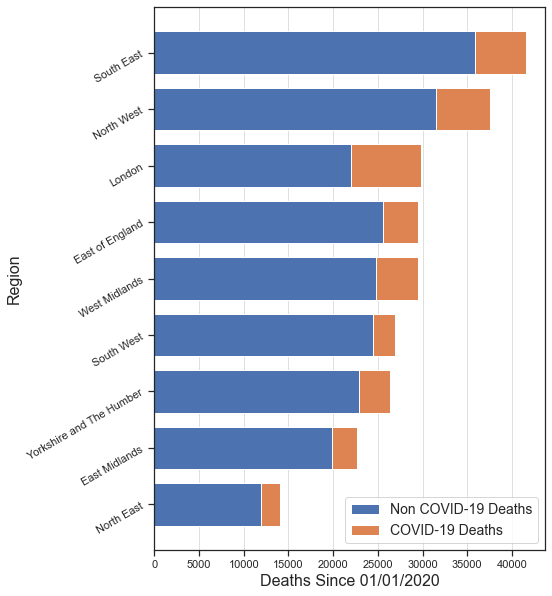

In [31]:
# region names
xs = total_deaths_by_region_df.index

# mortality counts
non_covid_deaths = total_deaths_by_region_df['Non COVID deaths']
covid_deaths = total_deaths_by_region_df['COVID deaths']

# set bar width
width = 0.75

# create a figure and plot data
plt.figure(figsize=(7,10))
p1 = plt.barh(xs, non_covid_deaths, width, label='Non COVID-19 Deaths')
p2 = plt.barh(xs, covid_deaths, width, left=non_covid_deaths, label='COVID-19 Deaths')

# label axes
plt.xlabel('Deaths Since 01/01/2020', fontsize=16)
plt.ylabel('Region', fontsize=16)
plt.yticks(rotation=30)

# add vertical grid lines
plt.gca().xaxis.grid(True, linestyle='-', which='major', color='grey', alpha=.25)

# show legend and plot
plt.legend(fontsize=14)
plt.show()

## Standardsied Mortality Rate by Region

Let's look at the age-standardised mortality rates per 100,000 people and standardised to the 2013 European Standard Population. Age-standardised mortality rates allow for differences in the age structure of populations and therefore allow valid comparisons to be made between geographical areas, the sexes and over time. 							

In [32]:
# Calculate the rate per 100k using the age-standardisation factor estimated previously
total_deaths_df['COVID-19 rate'] = (LAD_df.loc[total_deaths_df.index]['COVID-19 rate factor'] * total_deaths_df['COVID deaths']).astype(float)
total_deaths_df['All causes rate'] = (LAD_df.loc[total_deaths_df.index]['All causes rate factor'] * total_deaths_df['Total deaths']).astype(float)


In [33]:
# calculate the mean rate per region and sort
total_rates_df_by_region = total_deaths_df.groupby(by='Region name', as_index=False).agg('mean')
total_rates_df_by_region = total_rates_df_by_region.sort_values(by='COVID-19 rate', ascending=True)

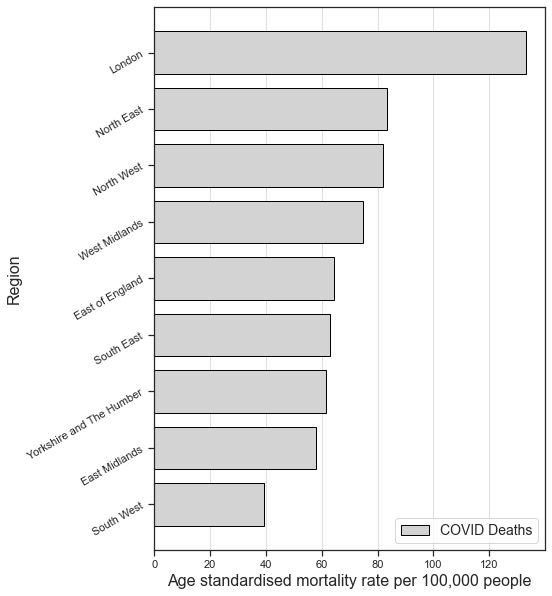

In [34]:
# region names
xs = total_rates_df_by_region['Region name']

# mortality counts
covid_deaths = total_rates_df_by_region['COVID-19 rate']

# set bar width
width = 0.75

# create a figure and plot data
plt.figure(figsize=(7,10))
p1 = plt.barh(xs, covid_deaths, width, label='COVID Deaths', edgecolor='black', color='lightgray')

# label axes
plt.xlabel('Age standardised mortality rate per 100,000 people', fontsize=16)
plt.ylabel('Region', fontsize=16)
plt.yticks(rotation=30)

# add vertical grid lines
plt.gca().xaxis.grid(True, linestyle='-', which='major', color='grey', alpha=.25)

# show legend and plot
plt.legend(loc='lower right', fontsize=14)
plt.show()

# Study 2 - Map Visualistaions

In this section, let's visualise some of the previous studies at a higher granularity by using a map. (Heavily based on code from https://github.com/DavidBeavan/coronavirus_covid-19).

First, weed to download a shapefile which defines the geographical boundaries of the different local authorities in England.

In [35]:
# specify URL
url = 'https://opendata.arcgis.com/datasets/1d78d47c87df4212b79fe2323aae8e08_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D'

# specify filename
filename = 'lad_boundaries.zip'

# construct file path
utla_download_dir = os.path.join(downloaded_data_dir, 'lad_boundaries')
filepath = os.path.join(utla_download_dir, filename)

# download and save file at the specified URL
download_file(url, filepath)

# unzip
myzipfile = zipfile.ZipFile(filepath)
myzipfile.extractall(utla_download_dir)

Next, we can load the shapefile into a GeoPandas DataFrame and extract the pieces we need.

In [36]:
# Load Local Authority District boundary shapefile
lad_boundaries_df = gpd.read_file(os.path.join(utla_download_dir, 
                        'Local_Authority_Districts__December_2019__Boundaries_UK_BFC.shp'))

# Remove Scotland and NI (for now, this is only parsing England data)
lad_boundaries_df = lad_boundaries_df[~lad_boundaries_df['lad19cd'].str.contains('^[SN]')]

# Remove Wales (for now, this is only parsing England data)
lad_boundaries_df = lad_boundaries_df[lad_boundaries_df['lad19nmw'].isnull()]

# Drop unused columns
lad_boundaries_df.drop(columns=['objectid', 'bng_e', 'lad19nmw', 'st_areasha', 
                      'bng_n', 'long', 'lat', 'st_lengths', 'lad19nm'], inplace=True)

# Index on ctyua19cd AKA region code
lad_boundaries_df.set_index('lad19cd', inplace=True)
lad_boundaries_df.index.name = 'Area code'

# remove LADs from the bondaries DataFrame if we do not have an entry for them in the LAD_df
lad_boundaries_df = lad_boundaries_df[lad_boundaries_df.index.isin(LAD_df.index)]

Let's add the boundary data to the mortality DataFrame we constructed earlier. We have to perform the join from `lad_boundaries_df` so that the resulting DataFrame is still a `GeoPandas` DataFrame.

In [37]:
mortality_geom_df = lad_boundaries_df.join(total_deaths_df)

Convinence function to make map plots.

In [38]:
def show_map(df, variable, title, size, cmap, limits=None):

    # Prep plot
    fig, ax = plt.subplots(1, figsize=size, facecolor='LightGray')

    # Zoom in to limits, if given
    if limits:
        ax.set_xlim(limits[0])
        ax.set_ylim(limits[1])

    # Plot map
    df.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='gray')

    # Remove the axis
    ax.axis('off')

    # Add title
    ax.set_title(title, fontdict={
                 'fontsize': 'xx-large', 'fontweight': 'bold'})

    # Add attributions
    #ax.annotate('Code: David Beavan Twitter:@DavidBeavan GitHub:https://github.com/DavidBeavan/coronavirus_covid-19\nPopulation estimates mid-2018\nSource: Office for National Statistics licensed under the Open Government Licence\nContains OS data © Crown copyright and database right 2019',
    #            xy=(0.02, .08), xycoords='figure fraction',
    #            horizontalalignment='left', verticalalignment='top',
    #            fontsize='medium', color='black')

    # Add legend
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=0, vmax=variable.max()))
    sm._A = []
    cbar = fig.colorbar(sm)

ImportError: The descartes package is required for plotting polygons in geopandas. You can install it using 'conda install -c conda-forge descartes' or 'pip install descartes'.

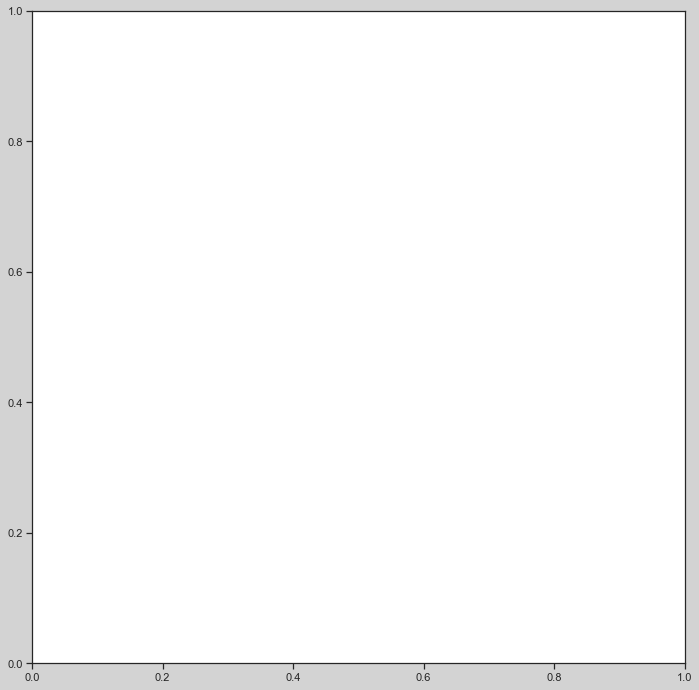

In [39]:
# make mortality rate map
show_map(mortality_geom_df, mortality_geom_df['COVID-19 rate'],
         'COVID-19 Mortality Rate (per 100,000)', (12, 12), 'Greys')

Looks reasonable when compared with Figure 3 from the [ONS publication](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsinvolvingcovid19bylocalareasanddeprivation/deathsoccurringbetween1marchand17april).

# Study 3 - Mortality by Depravation

In [40]:
# import mean IMD rank
total_deaths_df['Mean IMD decile'] = LAD_df['Mean IMD decile']


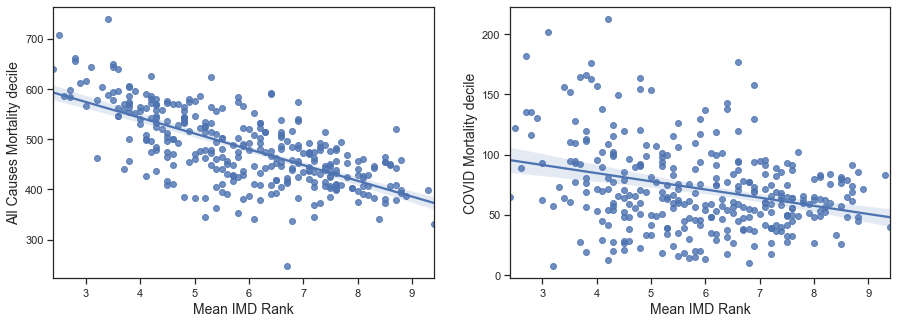

In [41]:
plt.figure(figsize=(15,5))

plt.subplot(121)
sns.regplot(x='Mean IMD decile', y='All causes rate', data=total_deaths_df)
plt.ylabel('All Causes Mortality decile', fontsize=14)
plt.xlabel('Mean IMD Rank', fontsize=14)

plt.subplot(122)
sns.regplot(x='Mean IMD decile', y='COVID-19 rate', data=total_deaths_df)
plt.ylabel('COVID Mortality decile', fontsize=14)
plt.xlabel('Mean IMD Rank', fontsize=14)

plt.show()